In [53]:
%matplotlib inline
import requests
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

Get data on foreign residents from e-stat api

In [56]:
pop_data = pd.read_csv('background-data/foreign-res-trim.csv')
pop_data["市区町村 コード"] = pop_data["市区町村 コード"].astype(str)
pop_data = pop_data.drop(['表章項目', '/国籍07', '韓国・朝鮮', 'ペルー'], axis=1)
pop_data['総数'] = pop_data['総数'].replace('-', 0)
pop_data.head()

,時間軸（月次）,市区町村 コード,市区町村,総数,中国,韓国,フィリピン,ブラジル,ベトナム,ネパール,米国,台湾,その他
0,2016年6月,1100,札幌市,10980,3777,2272,381,80,402,226,582,383,2877
1,2016年6月,1101,中央区,2345,724,502,56,9,118,46,203,112,575
2,2016年6月,1102,北区,2690,1152,299,61,15,59,75,91,95,843
3,2016年6月,1103,東区,1440,529,250,61,14,47,27,45,50,417
4,2016年6月,1104,白石区,795,212,237,47,7,36,14,42,13,187


In [57]:
#read data
bound_data = gpd.read_file('background-data/japan-utf.geojson')
#drop housing number
bound_data = bound_data.drop(['H_NUM'], axis=1)
#make pop data string, drop na's on JCODE and pass it to int then string to get rid of first 0
bound_data['P_NUM'] = bound_data['P_NUM'].astype(str)
bound_data = bound_data.dropna(axis=0, subset=['JCODE'])
bound_data['JCODE'] = pd.to_numeric(bound_data['JCODE'])
bound_data['JCODE'] = bound_data['JCODE'].astype(str)
bound_data.head()

,JCODE,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,CITY_ENG,P_NUM,geometry
0,1101,北海道,石狩振興局,None,札幌市,中央区,"Sapporo-shi, Chuo-ku",230382,"(POLYGON ((141.335036 43.069138, 141.342327 43..."
1,1102,北海道,石狩振興局,None,札幌市,北区,"Sapporo-shi, Kita-ku",283392,"(POLYGON ((141.398196 43.173398, 141.40002 43...."
2,1103,北海道,石狩振興局,None,札幌市,東区,"Sapporo-shi, Higashi-ku",259826,"(POLYGON ((141.447214 43.156114, 141.446976 43..."
3,1104,北海道,石狩振興局,None,札幌市,白石区,"Sapporo-shi, Shiroishi-ku",210479,"(POLYGON ((141.473458 43.096096, 141.449375 43..."
4,1105,北海道,石狩振興局,None,札幌市,豊平区,"Sapporo-shi, Toyohira-ku",219071,"(POLYGON ((141.366349 43.058047, 141.384713 43..."


In [73]:
merged_data = bound_data.merge(pop_data, how='left', right_on='市区町村 コード', left_on='JCODE')

merged_data.head()

,JCODE,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,CITY_ENG,P_NUM,geometry,時間軸（月次）,...,総数,中国,韓国,フィリピン,ブラジル,ベトナム,ネパール,米国,台湾,その他
0,1101,北海道,石狩振興局,None,札幌市,中央区,"Sapporo-shi, Chuo-ku",230382,"(POLYGON ((141.335036 43.069138, 141.342327 43...",2016年6月,...,2345,724,502,56,9,118,46,203,112,575
1,1102,北海道,石狩振興局,None,札幌市,北区,"Sapporo-shi, Kita-ku",283392,"(POLYGON ((141.398196 43.173398, 141.40002 43....",2016年6月,...,2690,1152,299,61,15,59,75,91,95,843
2,1103,北海道,石狩振興局,None,札幌市,東区,"Sapporo-shi, Higashi-ku",259826,"(POLYGON ((141.447214 43.156114, 141.446976 43...",2016年6月,...,1440,529,250,61,14,47,27,45,50,417
3,1104,北海道,石狩振興局,None,札幌市,白石区,"Sapporo-shi, Shiroishi-ku",210479,"(POLYGON ((141.473458 43.096096, 141.449375 43...",2016年6月,...,795,212,237,47,7,36,14,42,13,187
4,1105,北海道,石狩振興局,None,札幌市,豊平区,"Sapporo-shi, Toyohira-ku",219071,"(POLYGON ((141.366349 43.058047, 141.384713 43...",2016年6月,...,1273,374,399,48,7,25,10,71,50,289


Clean up unneeded data for now to reduce file-size

総数 column has "-" in place of 0 which means I can't turn it into an integer. Need to change - to 0.

In [74]:
merged_data = merged_data.drop(['JCODE', 'GUN', '時間軸（月次）', '市区町村 コード', '市区町村', 'その他', '台湾',
                                '米国', 'ネパール', 'ベトナム', 'ブラジル', 'フィリピン', '韓国', '中国'], axis=1)
merged_data['総数'] = merged_data['総数'].astype(float)
merged_data = merged_data.fillna(0)
merged_data['総数'] = merged_data['総数'].astype(int)
merged_data['P_NUM'] = merged_data['P_NUM'].astype(int)
merged_data = merged_data.assign(FOREIGN_RATIO=merged_data['総数']/merged_data['P_NUM'])

merged_data = merged_data.replace([np.inf, -np.inf], np.nan)
merged_data = merged_data.fillna(0)
merged_data['FOREIGN_RATIO'] = (merged_data['FOREIGN_RATIO']*100).round(decimals=1)
merged_data.head()

,KEN,SICHO,SEIREI,SIKUCHOSON,CITY_ENG,P_NUM,geometry,総数,FOREIGN_RATIO
0,北海道,石狩振興局,札幌市,中央区,"Sapporo-shi, Chuo-ku",230382,"(POLYGON ((141.335036 43.069138, 141.342327 43...",2345,1.0
1,北海道,石狩振興局,札幌市,北区,"Sapporo-shi, Kita-ku",283392,"(POLYGON ((141.398196 43.173398, 141.40002 43....",2690,0.9
2,北海道,石狩振興局,札幌市,東区,"Sapporo-shi, Higashi-ku",259826,"(POLYGON ((141.447214 43.156114, 141.446976 43...",1440,0.6
3,北海道,石狩振興局,札幌市,白石区,"Sapporo-shi, Shiroishi-ku",210479,"(POLYGON ((141.473458 43.096096, 141.449375 43...",795,0.4
4,北海道,石狩振興局,札幌市,豊平区,"Sapporo-shi, Toyohira-ku",219071,"(POLYGON ((141.366349 43.058047, 141.384713 43...",1273,0.6


In [75]:
#simplify
merged_data['geometry'] = merged_data['geometry'].simplify(0.0009, preserve_topology=True)

In [76]:
#export
merged_data.to_file("japan-merge.geojson", driver='GeoJSON')

In [79]:
#check that there are no nulls
merged_data['FOREIGN_RATIO'].max()

23.3

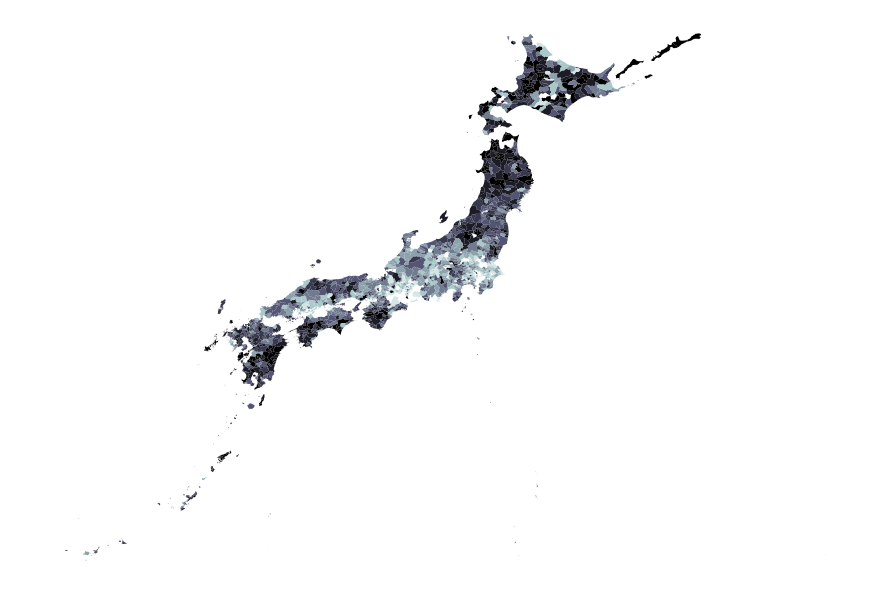

In [165]:
f, ax = plt.subplots(figsize=(15, 15), subplot_kw={'aspect': 'equal'})

merged_data.plot(column='FOREIGN_RATIO', scheme='quantiles', k=9, cmap='bone', ax=ax)
ax.set_axis_off()

In [150]:
import mapclassify as mc

In [70]:
merged_data.loc[merged_data['CITY_ENG']=='Kobe-shi, Suma-ku']

,KEN,SICHO,SEIREI,SIKUCHOSON,CITY_ENG,P_NUM,geometry,総数,FOREIGN_RATIO
1286,兵庫県,0,神戸市,須磨区,"Kobe-shi, Suma-ku",164942,"(POLYGON ((135.103554 34.635449, 135.105188 34...",3588,0.022


Shit theres multiples of the same polygons in there